代码改编自：https://github.com/tthustla/efficient_frontier/blob/master/Efficient%20_Frontier_implementation.ipynb

In [58]:
import data as web
import matplotlib.pyplot as plt
import scipy.optimize as sco
import seaborn as sns
import numpy as np
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
stocks = ['AAPL','AMZN','GOOGL','FB']
data = web.MultiTechData(symbols=stocks,begin='20160101',end='20171231',indicator='kline').multi_request(proxy=False)

访问股票 --> GOOGL
访问股票 --> FB
访问股票 --> AAPL
访问股票 --> AMZN
正在拼接数据，请稍等......
本次数据拼接完成..........


In [10]:
data.head()

,time,volume,open,high,low,close,chg,percent,turnoverrate,amount,volume_post,amount_post,symbol
0,2016-01-04,3369068,762.20,762.20,747.54,759.44,-18.57,-2.39,1.16,1.750486e+09,None,None,GOOGL
1,2016-01-05,2260795,764.10,769.20,755.65,761.53,2.09,0.28,0.78,1.210940e+09,None,None,GOOGL
2,2016-01-06,2410301,750.37,765.73,748.00,759.33,-2.20,-0.29,0.83,1.251004e+09,None,None,GOOGL
3,2016-01-07,3156563,746.49,755.31,735.28,741.00,-18.33,-2.41,1.09,1.642125e+09,None,None,GOOGL
4,2016-01-08,2375348,747.80,750.12,728.92,730.91,-10.09,-1.36,0.82,1.188273e+09,None,None,GOOGL


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2012 entries, 0 to 2011
Data columns (total 13 columns):
time            2012 non-null object
volume          2012 non-null int64
open            2012 non-null float64
high            2012 non-null float64
low             2012 non-null float64
close           2012 non-null float64
chg             2012 non-null float64
percent         2012 non-null float64
turnoverrate    2012 non-null float64
amount          2012 non-null float64
volume_post     0 non-null object
amount_post     0 non-null object
symbol          2012 non-null object
dtypes: float64(8), int64(1), object(4)
memory usage: 204.4+ KB


In [35]:
df = data.set_index('time')
table = df.pivot(columns='symbol',values='close')
table.head()

symbol,AAPL,AMZN,FB,GOOGL
time,,,,
2016-01-04,99.1174,636.99,102.22,759.44
2016-01-05,96.6336,633.79,102.73,761.53
2016-01-06,94.7425,632.65,102.97,759.33
2016-01-07,90.7439,607.94,97.92,741.00
2016-01-08,91.2238,607.05,97.33,730.91


Text(0, 0.5, 'price in $')

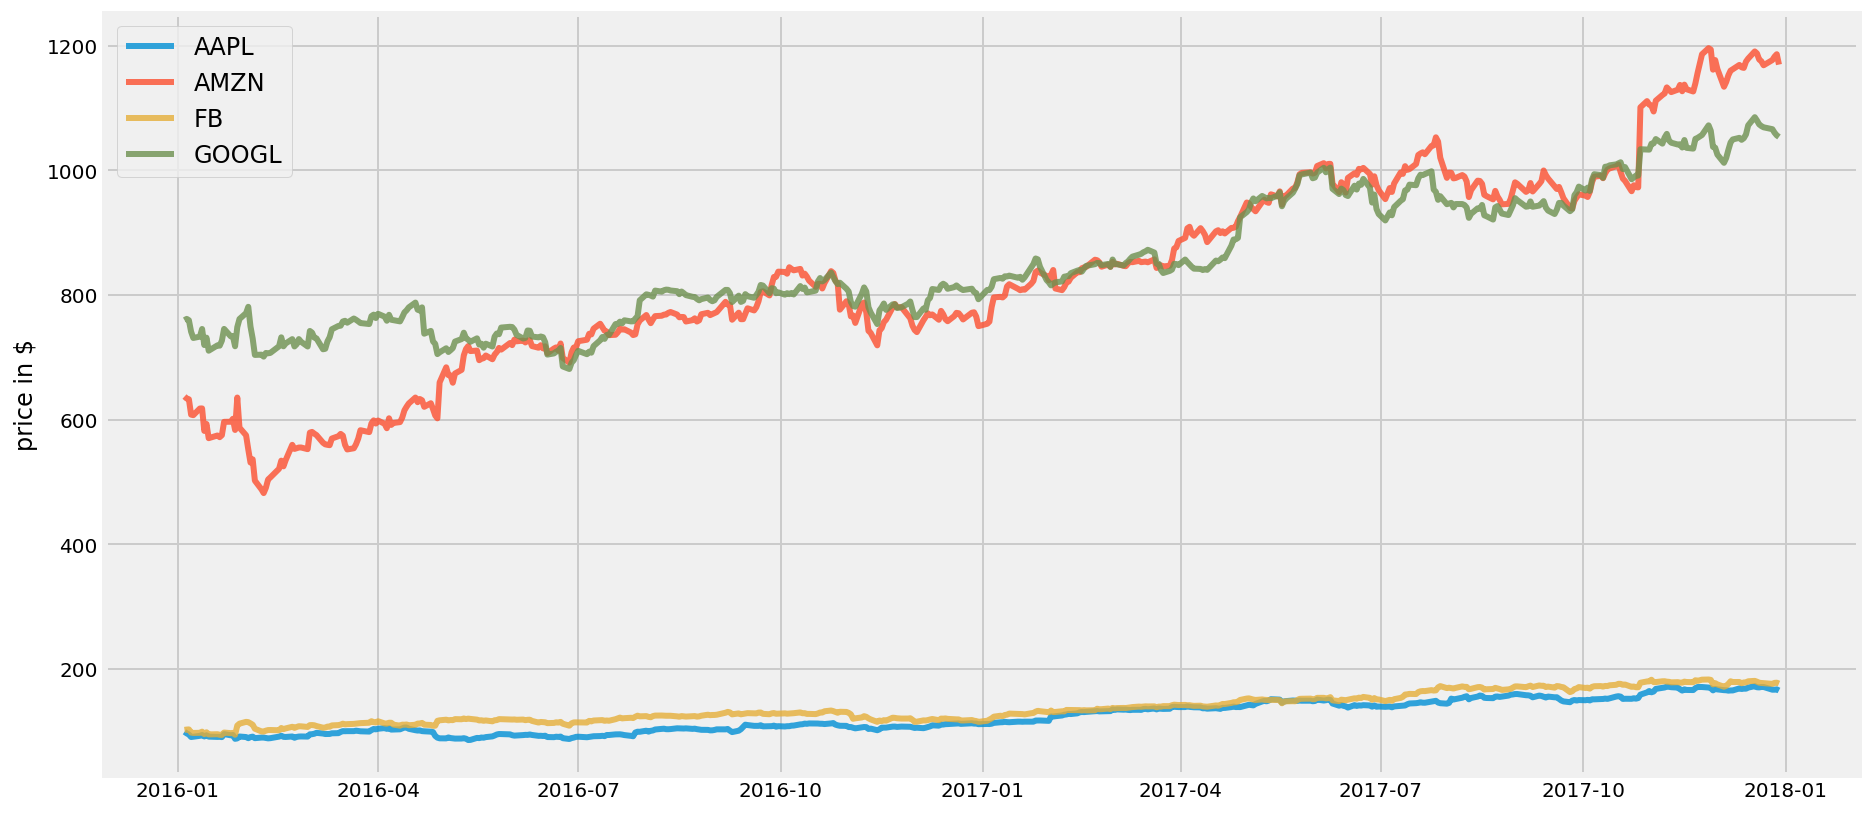

In [36]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

In [37]:
returns = table.pct_change()

Text(0, 0.5, 'daily returns')

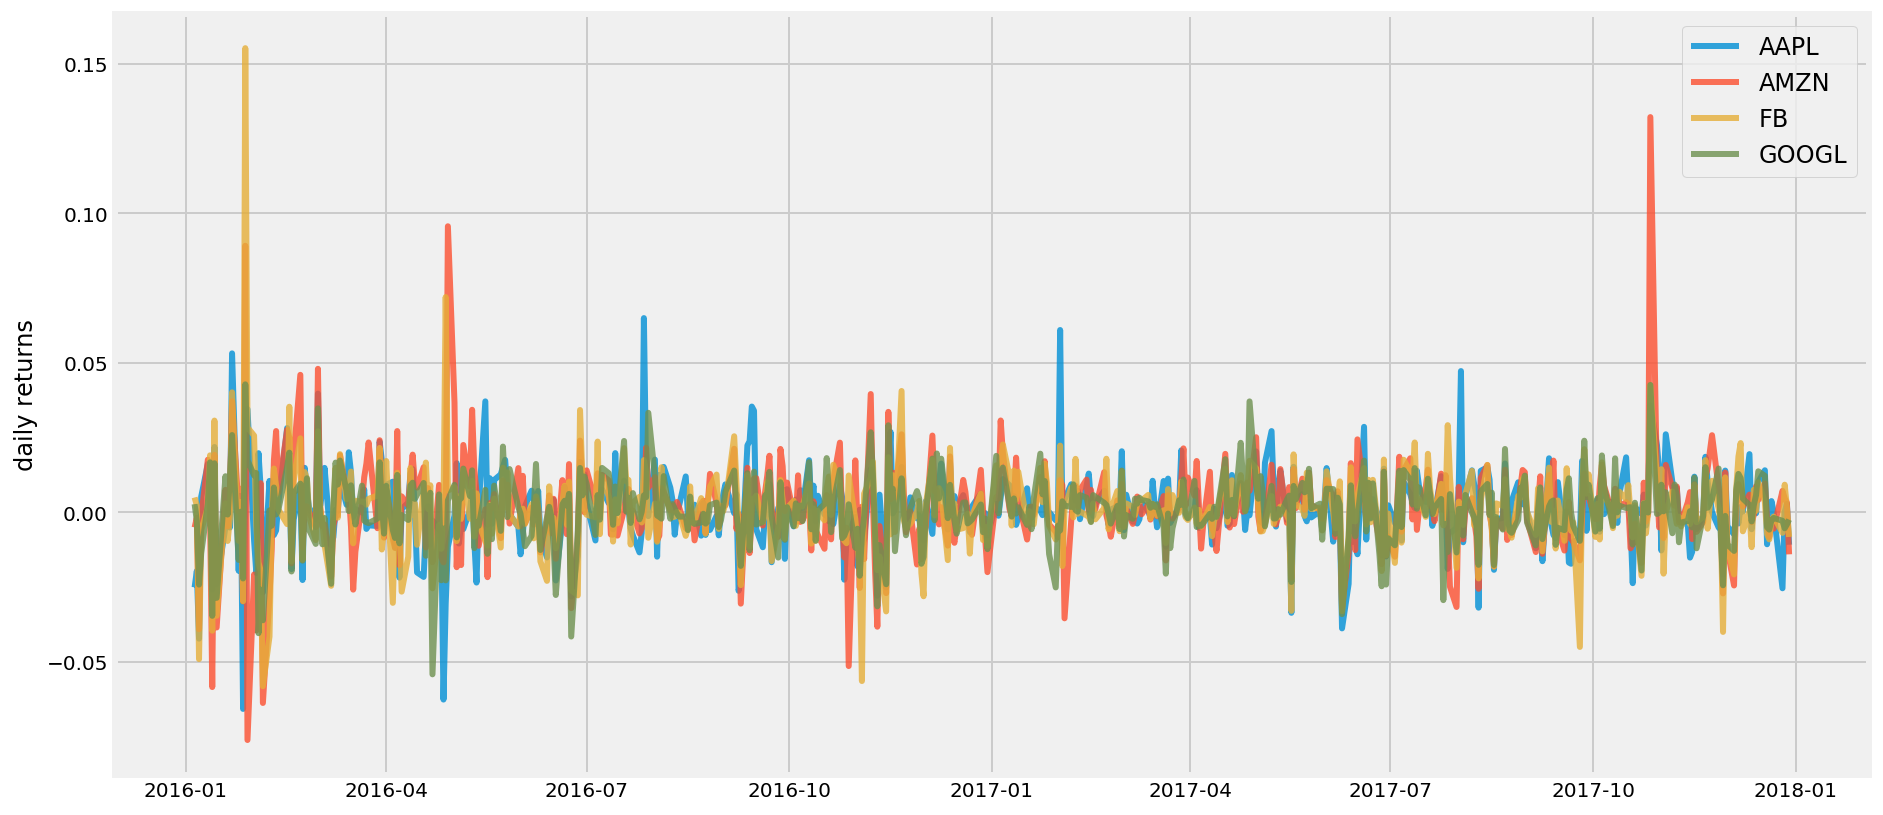

In [38]:
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

# Modern Portfolio Theory
A good portfolio is more than a long list of good stocks and bonds. it is a balanced whole, providing   
the investor with protections and opportunities with respect to a wide range of contingencies.   
 
                                                                           – Harry Markowitz

# Random Portfolios Generation
We have 4 stocks in our portfolio. One decision we have to make is how we should allocate our budget to each of stock in our portfolio. If our total budget is 1, then we can decide the weights for each stock, so that the sum of weights will be 1. And the value for weights will be the portion of budget we allocate to a specific stock. For example, if weight is 0.5 for Amazon, it means that we allocate 50% of our budget to Amazon.  

Let’s define some functions to simulate random weights to each stock in the portfolio, then calculate the portfolio’s overall annualised returns and annualised volatility.

“portfolio_annualised_performance” function will calculate the returns and volatility, and to make it as an annualised calculation I take into account 252 as the number of trading days in one year. “random_portfolios” function will generate portfolios with random weights assigned to each stock, and by giving num_portfolios argument, you can decide how many random portfolios you want to generate.

From the above code block, there are two things I want to point out.

# Portfolio standard deviation
The first is the calculation for portfolio’s volatility in “portfolio_annualised_performance” function. If you look up “portfolio standard deviation formula”, you will come across formulas as below.

$\sigma_{portfolio} = \sqrt[2]{w_1^2\sigma_1^2 + w_2^2\sigma_2^2 + 2w_1w_2Cov_{1,2}}$

$
\begin{bmatrix}
w_1 & w_2 \\
\end{bmatrix}
$
$
\begin{bmatrix}
\sigma_1^2 & \sigma_{1,2} \\
\sigma_{2,1}& \sigma_2^2 \\
\end{bmatrix}
$
$
\begin{bmatrix}
w_1 \\
w_2 \\
\end{bmatrix}
$
$ = $
$
\begin{bmatrix}
w_1\sigma_1^2 + w_2\sigma_{2,1} & w_1\sigma_{1,2}w_2\sigma_2^2 \\
\end{bmatrix}
$
$
\begin{bmatrix}
w_1 \\
w_2 \\
\end{bmatrix}
$


$ = w_1^2\sigma_1^2 + w_1w_2\sigma_{2,1} + w_1w_2\sigma_{2,1} + w_2^2\sigma_2^2$

$ = w_1^2\sigma_1^2 + 2w_1w_2\sigma_{2,1} + w_2^2\sigma_2^2$

With the above matrix calculation, we get the part inside the square root in the original formula. Now, all we need to do is put them inside the square root. Same as the annualised return, I took into account of 252 trading days (in this case, the square root of 252) to calculate the annualised standard deviation of a portfolio.

# Sharpe ratio
The second thing I would like to point out is the Sharpe ratio. In order to understand the Sharpe ratio, it is essential to understand the broader concept of risk-adjusted return. Risk-adjusted return refines an investment’s return by measuring how much risk is involved in producing that return, which is generally expressed as a number or rating. There could be a number of different methods of expressing risk-adjusted return, and the Sharpe ratio is one of them.

$Sharp Ratio = \frac{r_p - r_f}{\sigma_p}$

$r_p : Expected Portfoilio Return$


$r_f : Risk Free Rate$


$\sigma_p : Portfoilio Standard Deviation$

There are some criticisms on how the Sharpe ratio uses the standard deviation of returns as a denominator, which assumes the normal distribution of the returns. However, more often than not, the returns on financial assets tend to deviate from a normal distribution and may make interpretations of the Sharpe ratio misleading. It is for this reason that there are other methods which adjust or modify the original Sharpe ratio. But it is a more advanced topic, and I will stick to the traditional Sharpe ratio for this post.

Now let’s get the needed argument values for our functions. You can easily get daily returns by calling pct_change on the data frame with the price data. And the mean daily returns, the covariance matrix of returns are needed to calculate portfolio returns and volatility. We will generate 25,000 random portfolios. Finally, the risk-free rate has been taken from U.S. Department of The Treasury . The rate of 1.78% is the 52week treasury bill rates at the start of 2018. The rationale behind this is that the historical price data is from 2016~2017, and if I assume that I implement this analysis at the start of 2018, the most updated Treasury bill rate is from the start of 2018. And I also chose 52weeks treasury bill rates to match with the annualised return and risk I calculated.

In [43]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

Let me briefly explain what below function is doing. First, it generates random portfolio and gets the results (portfolio returns, portfolio volatility, portfolio Sharpe ratio) and weights for the corresponding result. Then by locating the one with the highest Sharpe ratio portfolio, it displays maximum Sharpe ratio portfolio as red star sign. And does similar steps for minimum volatility portfolio, and displays it as a green star on the plot. All the randomly generated portfolios will be also plotted with colour map applied to them based on the Sharpe ratio. Bluer, higher the Sharpe ratio.

And for these two optimal portfolios, it will also show how it allocates the budget within the portfolio.

In [52]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [55]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))  # 三行分别记录 portfolio_std_dev、portfolio_return、portfolio_sharp_ratio
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [60]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.18


symbol       AAPL   AMZN     FB  GOOGL
allocation  45.73  28.01  25.81   0.45
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.23
Annualised Volatility: 0.16


symbol       AAPL  AMZN    FB  GOOGL
allocation  33.61  1.34  8.02  57.02


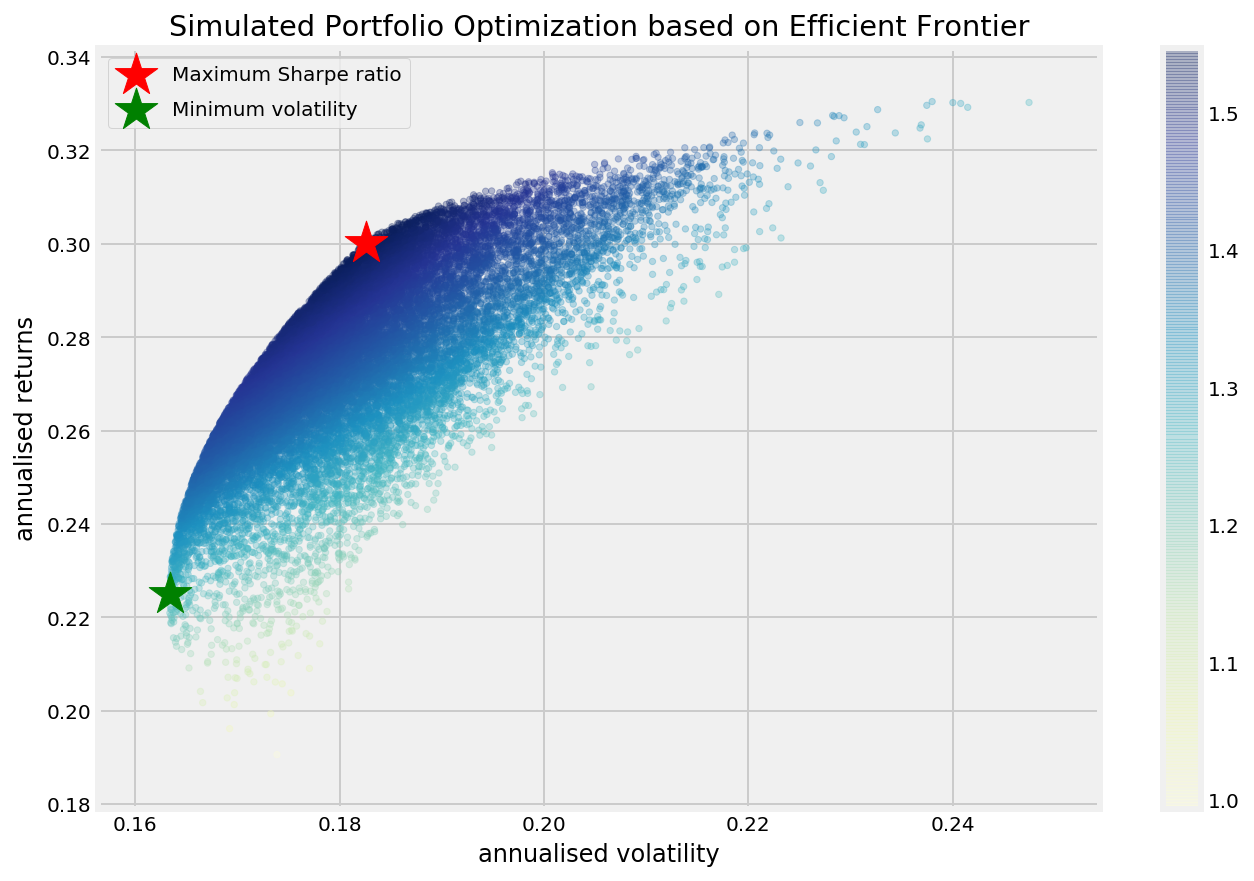

In [61]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

# Efficient Frontier
From the plot of the randomly simulated portfolio, we can see it forms a shape of an arch line on the top of clustered blue dots. This line is called efficient frontier. Why is it efficient? Because points along the line will give you the lowest risk for a given target return. All the other dots right to the line will give you higher risk with same returns. If the expected returns are the same, why would you take an extra risk when there's an option with lower risk?

The way we found the two kinds of optimal portfolio above was by simulating many possible random choices and pick the best ones (either minimum risk or maximum risk-adjusted return). We can also implement this by using Scipy's optimize function.

If you are an advanced Excel user, you might be familiar with 'solver' function in excel. Scipy's optimize function is doing the similar task when given what to optimize, and what are constraints and bounds.

Below functions are to get the maximum Sharpe ratio portfolio. In Scipy's optimize function, there's no 'maximize', so as an objective function you need to pass something that should be minimized. That is why the first "neg_sharpe_ratio" is computing the negative Sharpe ratio. Now we can use this as our objective function to minimize. In "max_sharpe_ratio" function, you first define arguments (this should not include the variables you would like to change for optimisation, in this case, "weights"). At first, the construction of constraints was a bit difficult for me to understand, due to the way it is stated.

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

The above constraint is saying that sum of x should be equal to 1. You can think of the 'fun' part construction as '1' on the right side of equal sign has been moved to the left side of the equal sign.

'np.sum(x) == 1' has become 'np.sum(x)-1'

And what does this mean? It simply means that the sum of all the weights should be equal to 1. You cannot allocate more than 100% of your budget in total.

"bounds" is giving another limit to assign random weights, by saying any weight should be inclusively between 0 and 1. You cannot give minus budget allocation to a stock or more than 100% allocation to a stock.

In [62]:

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

We can also define the optimizing function for calculating minimum volatility portfolio. This time we really do minimize the objective function. What do we want to minimize? We want to minimize volatility by trying different weights. "constraints" and "bounds" are same as the above.

In [63]:

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

As I already mentioned above we can also draw a line which depicts where the efficient portfolios for a given risk rate should be. This is called "efficient frontier". Below I define other functions to compute efficient frontier. The first function "efficient_return" is calculating the most efficient portfolio for a given target return, and the second function "efficient_frontier" will take a range of target returns and compute efficient portfolio for each return level.

In [64]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

Let's try to plot the portfolio choice with maximum Sharpe ratio and minimum volatility also with all the randomly generated portfolios. But this time we are not picking the optimal ones from the randomly generated portfolios, but we are actually calculating by using Scipy's 'minimize' function. And the below function will also plot the efficient frontier line.

In [66]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.18


symbol      AAPL   AMZN     FB  GOOGL
allocation  45.3  28.86  25.84    0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.22
Annualised Volatility: 0.16


symbol      AAPL  AMZN    FB  GOOGL
allocation  34.2  0.73  6.93  58.15


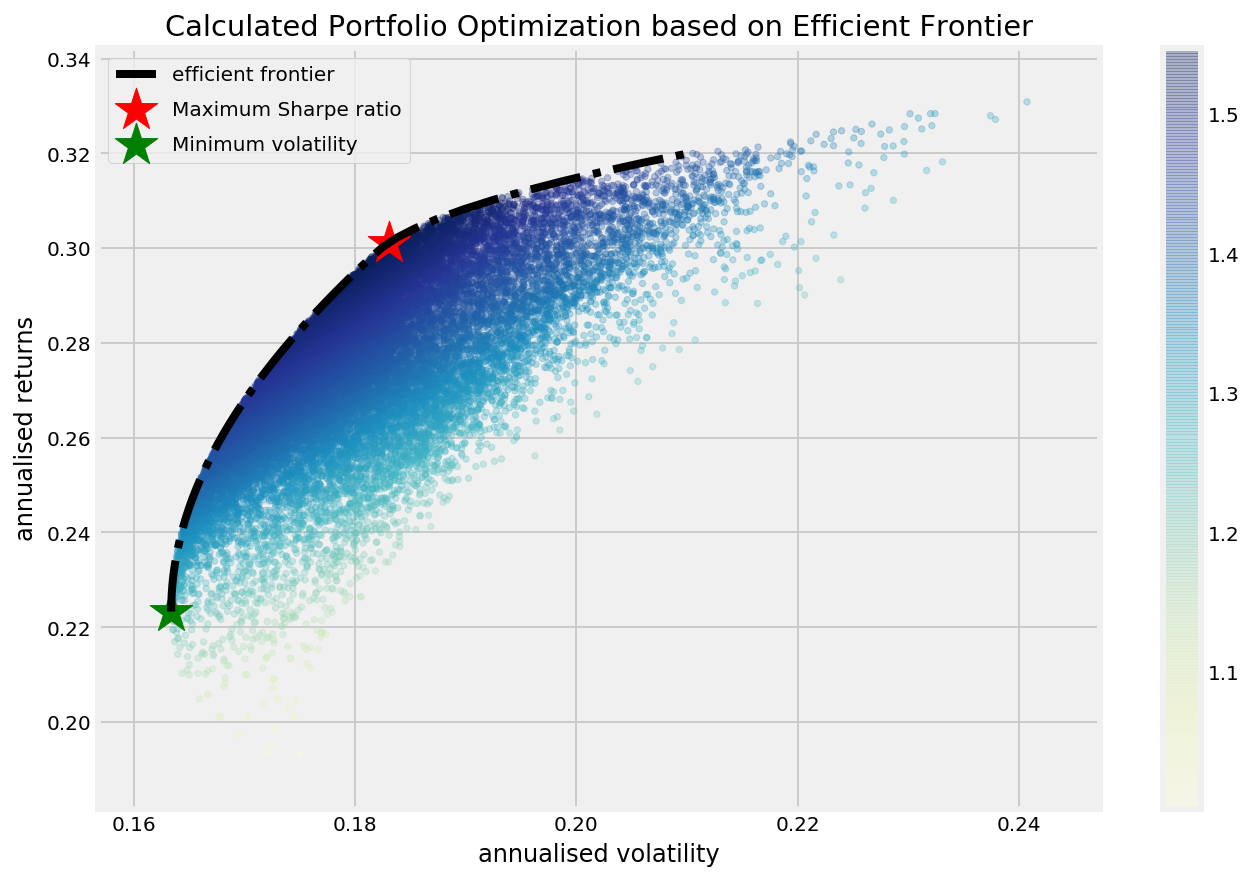

In [68]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

We have almost the same result as what we have simulated by picking from the randomly generated portfolios. The slight difference is that the Scipy's "optimize" function has not allocated any budget at all for Google on maximum Sharpe ratio portfolio, while one we chose from the randomly generated samples has 0.45% of allocation for Google. There are some differences in the decimal places but more or less same.

Instead of plotting every randomly generated portfolio, we can plot each individual stocks on the plot with the corresponding values of each stock's annual return and annual risk. This way we can see and compare how diversification is lowering the risk by optimising the allocation.

In [71]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    print("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print(txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.18


symbol      AAPL   AMZN     FB  GOOGL
allocation  45.3  28.86  25.84    0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.22
Annualised Volatility: 0.16


symbol      AAPL  AMZN    FB  GOOGL
allocation  34.2  0.73  6.93  58.15
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

AAPL : annuaised return 0.28 , annualised volatility: 0.21
AMZN : annuaised return 0.34 , annualised volatility: 0.25
FB : annuaised return 0.3 , annualised volatility: 0.23
GOOGL : annuaised return 0.18 , annualised volatility: 0.18
--------------------------------------------------------------------------------


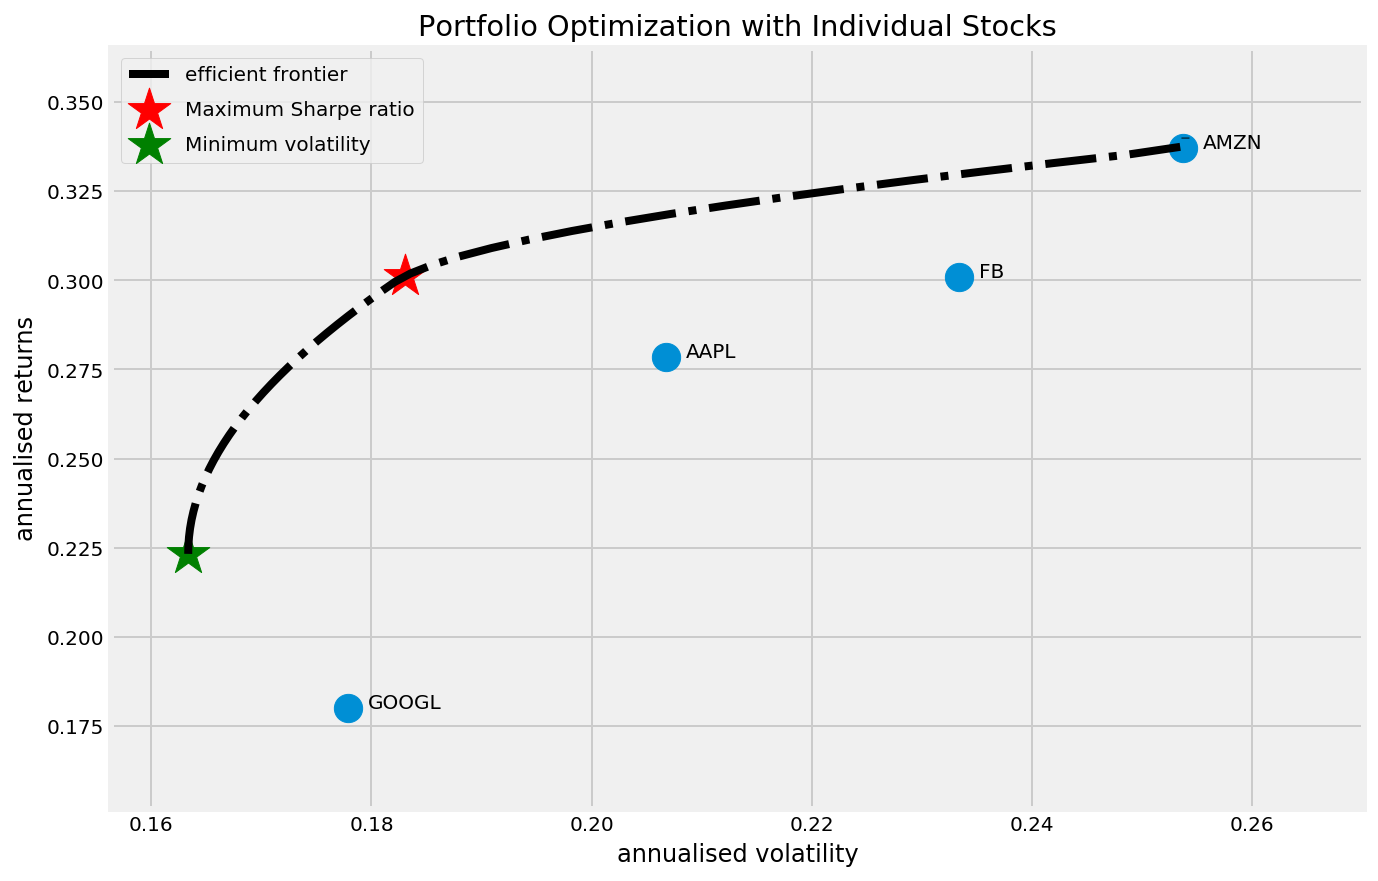

In [72]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

As you can see from the above plot, the stock with the least risk is Google at around 0.18. But with portfolio optimisation, we can achieve even lower risk at 0.16, and still with a higher return than Google. And if we are willing to take slightly more risk at around the similar level of risk of Google, we can achieve a much higher return of 0.30 with portfolio optimization.

Considering how vast and deep the finance field is, I've probably only scratched the surface. But I had fun going through coding and trying to understand the concept. And I'm learning every day. After finishing this implementation, I definitely know better than yesterday's me. And if I keep on going and learning, in about a couple of year's time, I will know a whole lot more than today's me. If you have any comments or questions, feel free to leave a comment. Any feedback would be appreciated.